In [ ]:
%load_ext autoreload
%autoreload 2

# Memory Information and GPU Information



In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.88GB
Used: 548.95MB
Percentage: 6.4%


In [ ]:
! nvidia-smi

Fri Jun  4 05:34:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Targets

Since, we have a Basic Skelton of the Archeiture ready, Now let's tweak the Number of Kernels being used and try to bring the count below 8000.

**Parameters**: Less than 8,000  
**Data Augmentations**: None  
**Regularization**: None  
**LR Scheduler**: None  
**No. of Epochs**: 14  


# Imports

In [ ]:
!git clone https://github.com/EVA6-Group-15/DLUtils.git dlutils

Cloning into 'dlutils'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import dlutils.plotter as plotter
import dlutils.train as train
import dlutils.test as test

# Data

In [ ]:
train_data_ = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()]))

In [ ]:
plotter.data_stats(train_data_)

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [ ]:
 torch.manual_seed(1)
batch_size = 64

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           shuffle=True, **kwargs)

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, **kwargs)

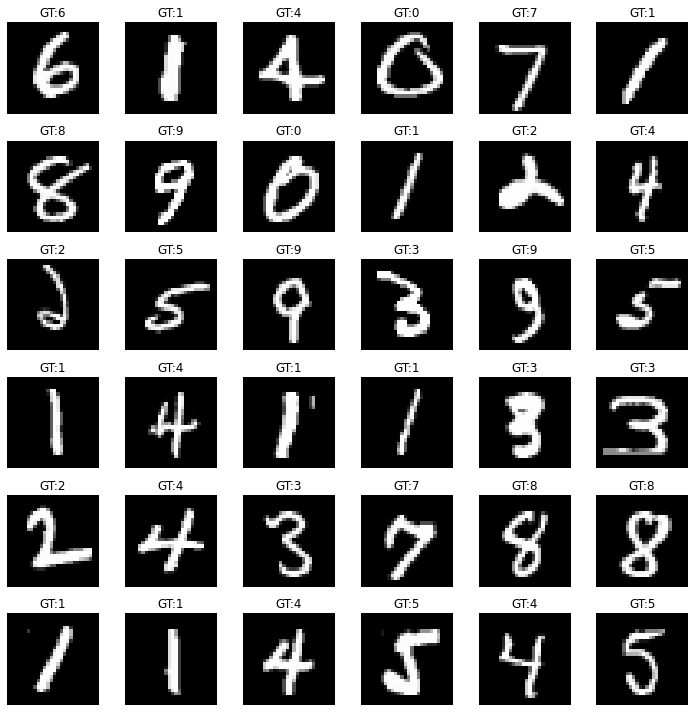

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
plotter.plot_data_grid(train_loader, mean= (0.1307,), std= (0.3081,), class_list=class_list, ncol=6,nrow=6)

# Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            # 28x28x1 -> 26x26x4
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8),
            # 26x26x4 -> 24x24x8
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8),
            # 24x24x8 -> 12x12x8
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.layer2 =  nn.Sequential(
            # 12x12x8 -> 10x10x16
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            # 10x10x12 -> 8x8x12
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            # 8x8x812-> 6x6x12
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            # 6x6x16 -> 4x4x16
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, bias=False)
        )
        
        # 4x4x16 -> 1x1x16
        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1),
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1)

        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = x.view(-1,10)

        return F.log_softmax(x, dim=1)

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]             576
              ReLU-5            [-1, 8, 24, 24]               0
       BatchNorm2d-6            [-1, 8, 24, 24]              16
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 12, 10, 10]             864
              ReLU-9           [-1, 12, 10, 10]               0
      BatchNorm2d-10           [-1, 12, 10, 10]              24
           Conv2d-11             [-1, 12, 8, 8]           1,296
             ReLU-12             [-1, 12, 8, 8]               0
      BatchNorm2d-13             [-1, 12, 8, 8]              24
           Conv2d-14             [-1, 1

# Training

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainer = train.Train(model, device, train_loader, optimizer)
tester = test.Test(model, device, test_loader)

for epoch in range(1, 15):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer()
    test_loss, test_acc = tester()
    
    print('TRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


loss=0.14374232292175293 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 58.58it/s]


TRAIN set: Average loss: 0.2318, Train Accuracy: 92.66%
TEST set: Average loss: 0.0443, Test Accuracy: 98.65%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 0.0520, Train Accuracy: 98.35%
TEST set: Average loss: 0.0411, Test Accuracy: 98.70%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.0404, Train Accuracy: 98.73%
TEST set: Average loss: 0.0360, Test Accuracy: 98.92%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.0334, Train Accuracy: 98.95%
TEST set: Average loss: 0.0432, Test Accuracy: 98.66%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.0313, Train Accuracy: 98.98%
TEST set: Average loss: 0.0290, Test Accuracy: 99.11%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.0261, Train Accuracy: 99.16%
TEST set: Average loss: 0.0290, Test Accuracy: 99.04%


# Results

In [ ]:
print('Train Accuracy:', max(trainer.accuracy))
print('Test Accuracy:', max(tester.accuracy))

Train Accuracy: 99.51
Test Accuracy: 99.22


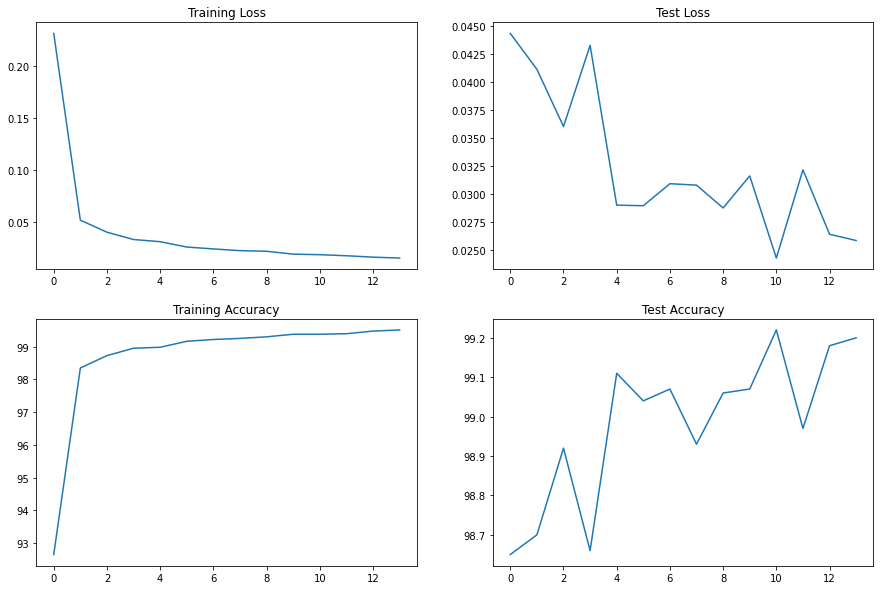

In [ ]:
plotter.plot_loss_acc(trainer.loss, trainer.accuracy, tester.loss, tester.accuracy)

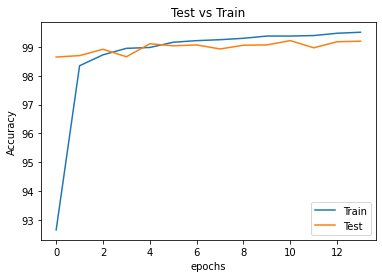

In [ ]:
plotter.plot_combined(trainer.accuracy, tester.accuracy,  x_label='epochs', y_label='Accuracy')

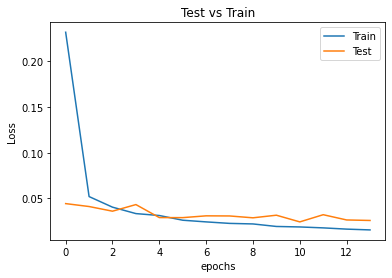

In [ ]:
plotter.plot_combined(trainer.loss, tester.loss,  x_label='epochs', y_label='Loss')

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results = plotter.Results(model, test_loader, device, mean, std, class_list)

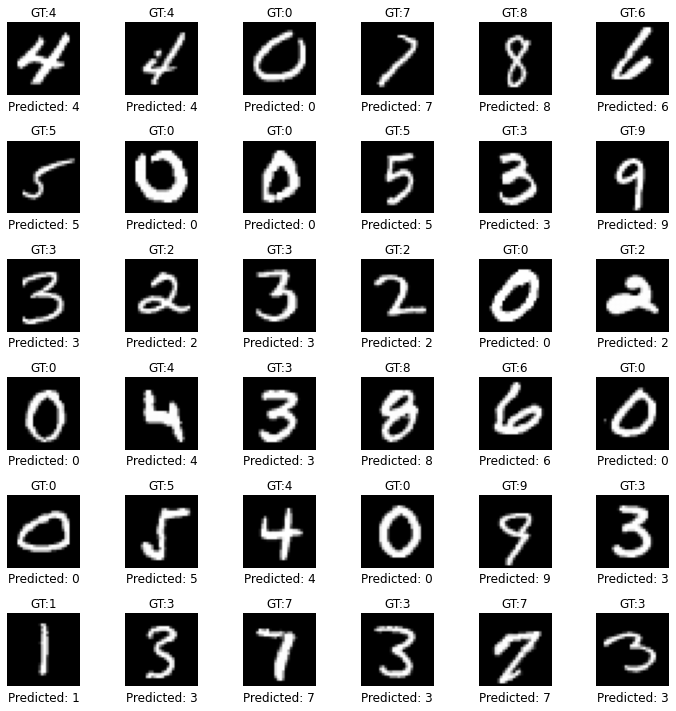

In [ ]:
results.plot_batch(6,6)

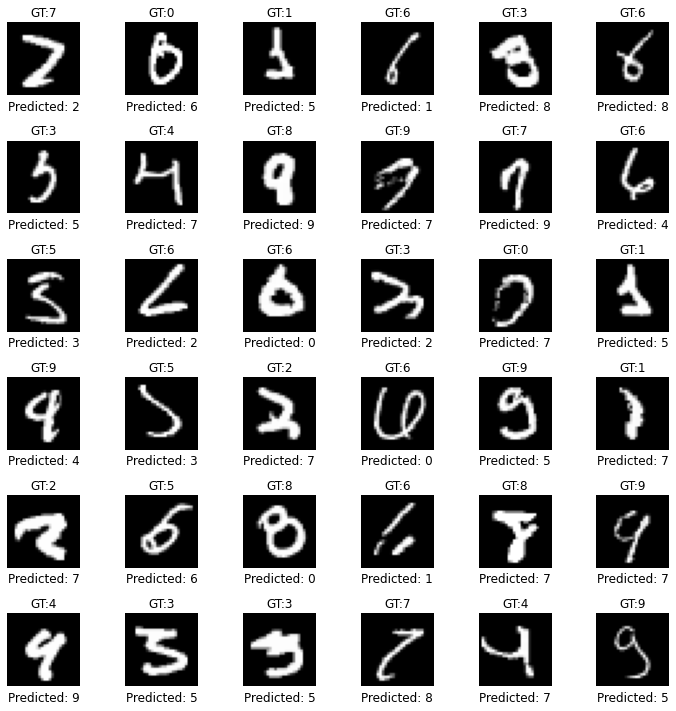

In [ ]:
results.plot_incorrect()

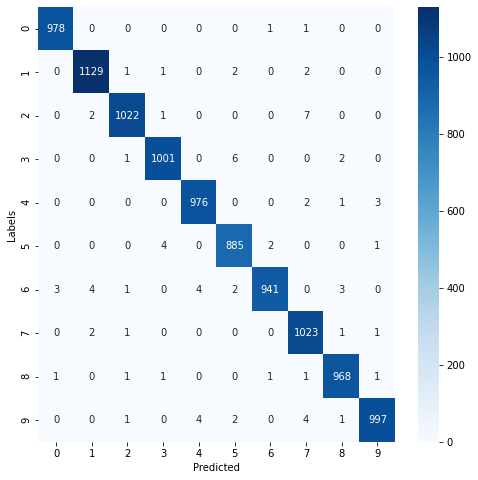

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class 6 is 98.23
Accuracy of class 9 is 98.81
Accuracy of class 2 is 99.03
Accuracy of class 3 is 99.11
Accuracy of class 5 is 99.22
Accuracy of class 8 is 99.38
Accuracy of class 4 is 99.39
Accuracy of class 1 is 99.47
Accuracy of class 7 is 99.51
Accuracy of class 0 is 99.80


In [ ]:
results.class_accuracy()

# Model Architecture

In [ ]:
!pip3 install hiddenlayer

In [ ]:
import hiddenlayer as hl
model = Net().to('cuda')
network_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/network_1", "png")

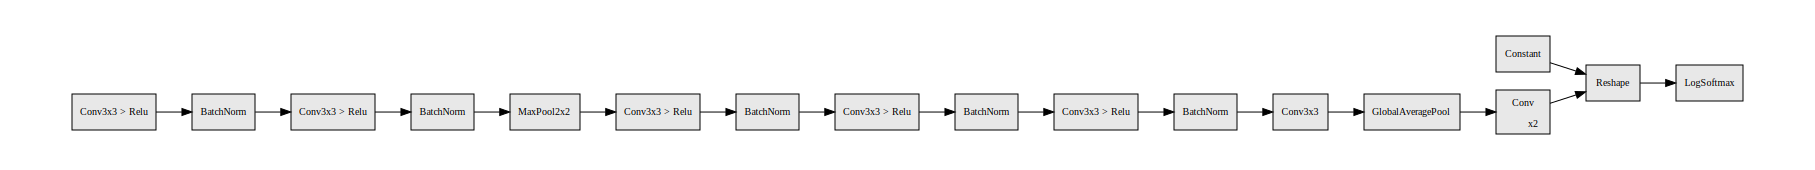

In [ ]:
network_graph

# Acheviements

**Total Parameters Used**: 7,826  
**Train Accuracy**: 99.51  
**Test Accuracy**: **99.22**  
**Consistent From**: Not Consistent  
**Data Augmentation**: None


## Analysis

We have got the Parameters Count, to where we wanted, below **8000**. The model is still able to learn as we see that the training accuracy is going to 99.5 even with below 8000 parameters.

Now we can use this Model with lesser parameters, and add Regularization using DropOut or do some Data Augmentation to improve Test Accuracy, as we again see that there is still Over fitting going on